In [2]:
import itertools

import yaml
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

import lab.metrics
import lab.analytics

In [60]:
def load_classifier_prediction(classifier: str, factor: str, rep: int):
    return pd.read_csv(
        f"../../results/ml-eval/predictions/{factor}/{classifier}-{rep}.csv",
        header=0
    )

def load_results():
    combinations = [
        (classifier, factor, rep) for classifier in ["kfp"]
        for factor in ["sim-front-dataset-filtered", "front-dataset-filtered", "sim-tamaraw-dataset-filtered", "tamaraw-dataset-filtered"]
        for rep in range(10)
    ]
        
    return (pd.concat([
        load_classifier_prediction(classifier, factor, rep)
        for (classifier, factor, rep) in combinations
    ], keys=combinations, names=["classifier", "factor", "run", "sample"])
            .fillna(0)
            .rename(columns=lambda c: int(c) if c != "y_true" else c)
            .drop(columns=[-1]))


data = load_results()
data

y_true    0    1    2    3  \
classifier factor                     run sample                               
kfp        sim-front-dataset-filtered 0   0          0.0  1.0  0.0  0.0  0.0   
                                          1          0.0  1.0  0.0  0.0  0.0   
                                          2          0.0  1.0  0.0  0.0  0.0   
                                          3          0.0  1.0  0.0  0.0  0.0   
                                          4          0.0  1.0  0.0  0.0  0.0   
...                                                  ...  ...  ...  ...  ...   
           tamaraw-dataset-filtered   9   1953      -1.0  0.0  0.0  0.0  0.0   
                                          1954      -1.0  0.0  0.0  0.0  0.0   
                                          1955      -1.0  0.0  0.0  0.0  0.0   
                                          1956      -1.0  0.0  0.0  0.0  0.0   
                                          1957      -1.0  0.0  0.0  0.0  0.0   

                                                    4    5    6    7    8  \
classifier factor                     run sample                            
kfp        sim-front-dataset-filtered 0   0       0.0  0.0  0.0  0.0  0.0   
                                          1       0.0  0.0  0.0  0.0  0.0   
                                          2       0.0  0.0  0.0  0.0  0.0   
                                          3       0.0  0.0  0.0  0.0  0.0   
                                          4       0.0  0.0  0.0  0.0  0.0   
...                                               ...  ...  ...  ...  ...   
           tamaraw-dataset-filtered   9   1953    0.0  0.0  0.0  0.0  0.0   
                                          1954    0.0  0.0  0.0  0.0  0.0   
                                          1955    0.0  0.0  0.0  0.0  0.0   
                                          1956    0.0  0.0  0.0  0.0  0.0   
                                          1957    0.0  0.0  0.0  0.0  0.0   

                                                  ...  114  115  116  117  \
classifier factor                     run sample  ...                       
kfp        sim-front-dataset-filtered 0   0       ...  0.0  0.0  0.0  0.0   
                                          1       ...  0.0  0.0  0.0  0.0   
                                          2       ...  0.0  0.0  0.0  0.0   
                                          3       ...  0.0  0.0  0.0  0.0   
                                          4       ...  0.0  0.0  0.0  0.0   
...                                               ...  ...  ...  ...  ...   
           tamaraw-dataset-filtered   9   1953    ...  0.0  0.0  0.0  0.0   
                                          1954    ...  0.0  0.0  0.0  0.0   
                                          1955    ...  0.0  0.0  0.0  0.0   
                                          1956    ...  0.0  0.0  0.0  0.0   
                                          1957    ...  0.0  0.0  0.0  0.0   

                                                  118  119  120  121  122  123  
classifier factor                     run sample                                
kfp        sim-front-dataset-filtered 0   0       0.0  0.0  0.0  0.0  0.0  0.0  
                                          1       0.0  0.0  0.0  0.0  0.0  0.0  
                                          2       0.0  0.0  0.0  0.0  0.0  0.0  
                                          3       0.0  0.0  0.0  0.0  0.0  0.0  
                                          4       0.0  0.0  0.0  0.0  0.0  0.0  
...                                               ...  ...  ...  ...  ...  ...  
           tamaraw-dataset-filtered   9   1953    0.0  0.0  0.0  0.0  0.0  0.0  
                                          1954    0.0  0.0  0.0  0.0  0.0  0.0  
                                          1955    0.0  0.0  0.0  0.0  0.0  0.0  
                                          1956    0.0  0.0  0.0  0.0  0.0  0.0  
                                 

In [43]:
def precision_recall_curve(df):
    return pd.DataFrame(lab.analytics.rprecision_recall_curve(
        df["y_true"], df.drop("y_true", axis=1), ratio=20
    )._asdict())

In [57]:
def plot_pr_curve(data):
    data = (data
            .transform(lambda x: x*100)
            .rename({"dfnet": "DF", "varcnn": "Var-CNN", "p1fp": "$p$-FP(C)", "kfp": "$k$-FP"}, axis=0)
            .rename({"precision": "$\pi_{20}$ (\%)", "recall": "Recall (\%)"}, axis=1)
            .reset_index())
    display(data)

    with plt.style.context([]):#"./mpl-style/pr-curve.mplstyle", "./mpl-style/pets.mplstyle", {"text.usetex": True}]):
        grid = sns.relplot(
            data=data, x="Recall (\%)", y="$\pi_{20}$ (\%)", hue="factor",
            style="factor", col="classifier", kind="line", 
            facet_kws=dict(legend_out=True, despine=False,
                           gridspec_kws=dict(wspace=.1)),
            palette="binary", legend=True
        )
        grid.set_titles(col_template="{col_name}")
        
        for i, ax in enumerate(np.ravel(grid.axes)):
            # if i == 0:
            #     ax.legend(labels=["Unmon.", "Control", "Both"])
            ax.set_xticks([0, 50, 100])
            ax.set_yticks([0, 50, 100])
            ax.xaxis.get_major_formatter()._usetex = False
            ax.yaxis.get_major_formatter()._usetex = False
        
    return grid

,classifier,factor,level_2,thresholds,$\pi_{20}$ (\%),Recall (\%)
0,$k$-FP,front-dataset-filtered,0,0.000,3.328474,69.897959
1,$k$-FP,front-dataset-filtered,1,0.167,16.464825,63.959184
2,$k$-FP,front-dataset-filtered,2,0.333,16.464825,63.959184
3,$k$-FP,front-dataset-filtered,3,0.500,22.124878,57.448980
4,$k$-FP,front-dataset-filtered,4,0.667,33.440912,45.959184
5,$k$-FP,front-dataset-filtered,5,0.833,33.440912,45.959184
6,$k$-FP,front-dataset-filtered,6,1.000,41.772481,38.346939
7,$k$-FP,sim-front-dataset-filtered,0,0.000,3.547619,74.500000
8,$k$-FP,sim-front-dataset-filtered,1,0.167,18.026097,69.350000
9,$k$-FP,sim-front-dataset-filtered,2,0.333,18.026097,69.350000


/home/jsmith/Projects/quic-client-defence/code/qcd-experiments/env/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout(*args, **kwargs)
/home/jsmith/Projects/quic-client-defence/code/qcd-experiments/env/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout(*args, **kwargs)


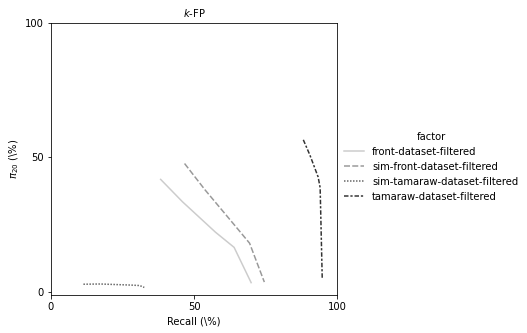

In [64]:
figure = (data.groupby(["classifier", "factor"])
          .apply(precision_recall_curve)
          .set_index("thresholds", append=True)
          .pipe(plot_pr_curve))

figure.savefig("/tmp/pr-curve.png", dpi=150, bbox_inches="tight")
# figure.savefig("../results/plots/quic-presence-prcurve.pgf", dpi=150, bbox_inches="tight")

In [62]:
def make_binary_predictions(data):
    data = data.copy()
    data["score"] = data[np.arange(0, 100)].sum(axis=1)
    data["y_true"] = data["y_true"].where(data["y_true"] == -1, 0).astype(int)
    return data[["y_true", "score"]]

binary_data = (make_binary_predictions(data)
               .groupby(["classifier", "factor"])
               .apply(precision_recall_curve)
               .set_index("thresholds", append=True))
binary_data

precision    recall
classifier factor                         thresholds                     
kfp        front-dataset-filtered       0 0.000        0.047619  1.000000
                                        1 0.167        0.163383  0.792653
                                        2 0.333        0.163383  0.792653
                                        3 0.500        0.230355  0.675918
                                        4 0.667        0.304244  0.569286
                                        5 0.833        0.304244  0.569286
                                        6 1.000        0.388825  0.448571
           sim-front-dataset-filtered   0 0.000        0.047619  1.000000
                                        1 0.167        0.177133  0.827900
                                        2 0.333        0.177133  0.827900
                                        3 0.500        0.242741  0.731500
                                        4 0.667        0.330777  0.629700
                                        5 0.833        0.330777  0.629700
                                        6 1.000        0.434135  0.521700
           sim-tamaraw-dataset-filtered 0 0.000        0.047619  1.000000
                                        1 0.167        0.060301  0.639677
                                        2 0.333        0.060301  0.639677
                                        3 0.500        0.067237  0.576855
                                        4 0.667        0.078282  0.409677
                                        5 0.833        0.078282  0.409677
                                        6 1.000        0.083074  0.257258
           tamaraw-dataset-filtered     0 0.000        0.047619  1.000000
                                        1 0.167        0.395026  0.975510
                                        2 0.333        0.395026  0.975510
                                        3 0.500        0.437804  0.967653
                                        4 0.667        0.505092  0.951122
                                        5 0.833        0.505092  0.951122
                                        6 1.000        0.555284  0.926327

,classifier,factor,level_2,thresholds,$\pi_{20}$ (\%),Recall (\%)
0,$k$-FP,front-dataset-filtered,0,0.000,4.761905,100.000000
1,$k$-FP,front-dataset-filtered,1,0.167,16.338266,79.265306
2,$k$-FP,front-dataset-filtered,2,0.333,16.338266,79.265306
3,$k$-FP,front-dataset-filtered,3,0.500,23.035500,67.591837
4,$k$-FP,front-dataset-filtered,4,0.667,30.424449,56.928571
5,$k$-FP,front-dataset-filtered,5,0.833,30.424449,56.928571
6,$k$-FP,front-dataset-filtered,6,1.000,38.882452,44.857143
7,$k$-FP,sim-front-dataset-filtered,0,0.000,4.761905,100.000000
8,$k$-FP,sim-front-dataset-filtered,1,0.167,17.713259,82.790000
9,$k$-FP,sim-front-dataset-filtered,2,0.333,17.713259,82.790000


/home/jsmith/Projects/quic-client-defence/code/qcd-experiments/env/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout(*args, **kwargs)
/home/jsmith/Projects/quic-client-defence/code/qcd-experiments/env/lib/python3.8/site-packages/seaborn/axisgrid.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout(*args, **kwargs)


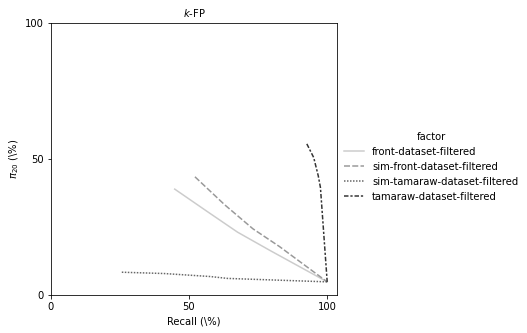

In [63]:
figure = plot_pr_curve(binary_data)

# figure.savefig("../results/plots/quic-presence-prcurve-binary.png", dpi=150, bbox_inches="tight")
# figure.savefig("../results/plots/quic-presence-prcurve-binary.pgf", dpi=150, bbox_inches="tight")